<center>
<img src="https://habrastorage.org/files/fd4/502/43d/fd450243dd604b81b9713213a247aa20.jpg">
## Open Machine Learning Course
<center>Author: [Yury Kashnitsky](http://yorko.github.io). All content is distributed under the [Creative Commons CC BY-NC-SA 4.0](https://creativecommons.org/licenses/by-nc-sa/4.0/) license.

# <center>Topic 9. Time series analysis with Python</center>
## <center>Analyzing accidental deaths in US with ARIMA</center>

[Introduction to ARIMA](https://www.youtube.com/watch?v=Y2khrpVo6qI).


We know monthly numbers of accidental deaths in the US from January 1973 till December 1978. Let's build predictions for next 2 years.

In [15]:
import warnings
warnings.filterwarnings('ignore')

%matplotlib inline
from matplotlib import pyplot as plt
plt.rcParams['figure.figsize'] = 12, 10
import pandas as pd
from scipy import stats
import statsmodels.api as sm
import matplotlib.pyplot as plt
from itertools import product

**Read and plot data. We can clearly notice seasonality.**

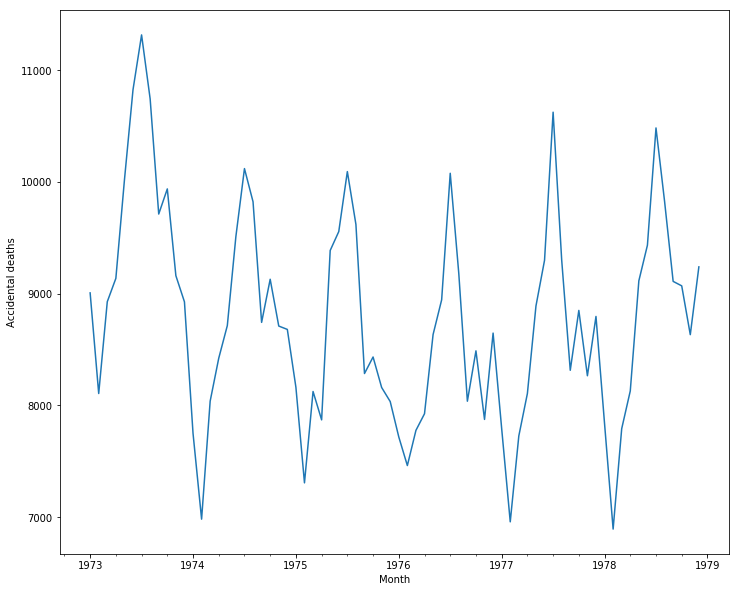

In [16]:
deaths = pd.read_csv('../input/accidental-deaths-in-usa-monthly.csv',
                   index_col=['Month'], parse_dates=['Month'])
deaths.rename(columns={'Accidental deaths in USA: monthly, 1973 ? 1978': 'num_deaths'}, inplace=True)
deaths['num_deaths'].plot()
plt.ylabel('Accidental deaths');

1. **Checking stationarity and performing STL decomposition ([Seasonal and Trend decomposition using Loess](https://otexts.org/fpp2/stl.html))**

Dickey-Fuller criterion: p=0.102481


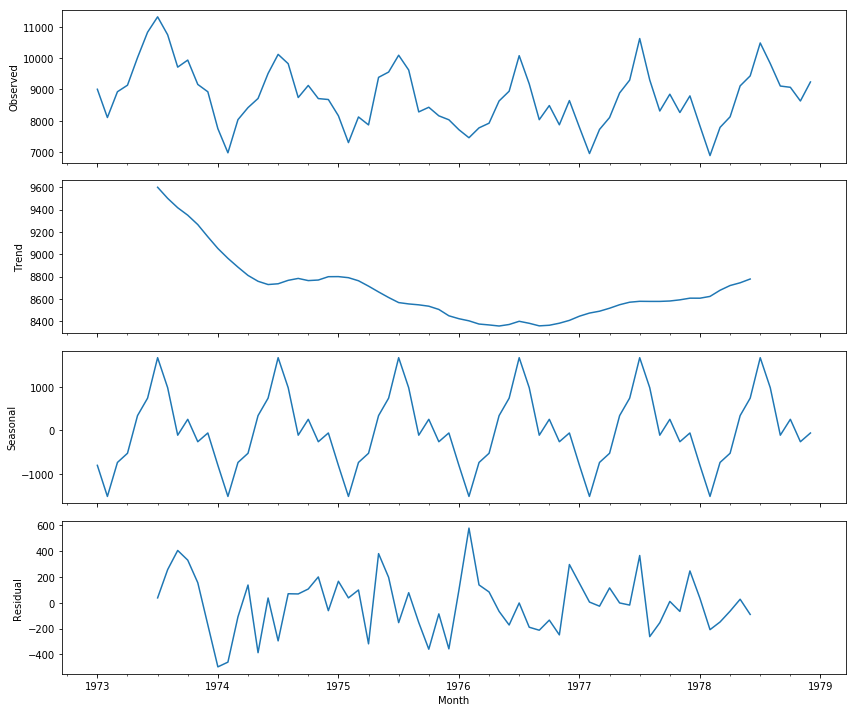

In [17]:
sm.tsa.seasonal_decompose(deaths['num_deaths']).plot()
print("Dickey-Fuller criterion: p=%f" % 
      sm.tsa.stattools.adfuller(deaths['num_deaths'])[1])

### Stationarity

Dickey-Fuller criteriom does not reject the non-stationarity null-hypothesis, but we still see a trend. Let's perform seasonal differentiation, then check again stationarity and perform STL decomposition:

Dickey-Fuller criterion: p=0.014650


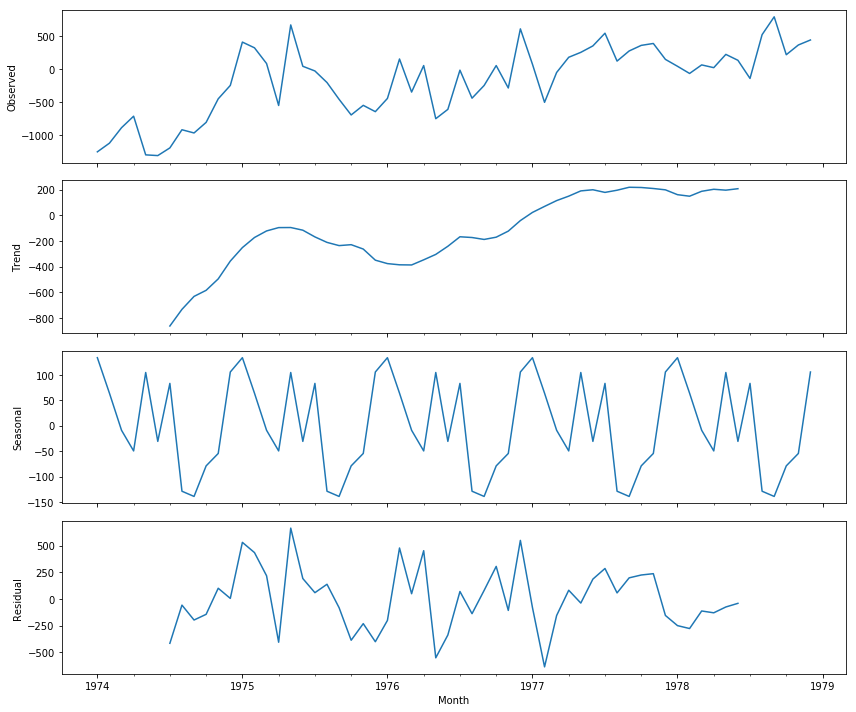

In [18]:
deaths['num_deaths_diff'] = deaths['num_deaths'] - \
                            deaths['num_deaths'].shift(12)
sm.tsa.seasonal_decompose(deaths['num_deaths_diff'][12:]).plot()
print("Dickey-Fuller criterion: p=%f" % 
      sm.tsa.stattools.adfuller(deaths['num_deaths_diff'][12:])[1])

Dickey-Fuller criteriom does now rejects the non-stationarity null-hypothesis, but we still see a trend. Let's now perform one more differentiation.

Dickey-Fuller criterion: p=0.000000


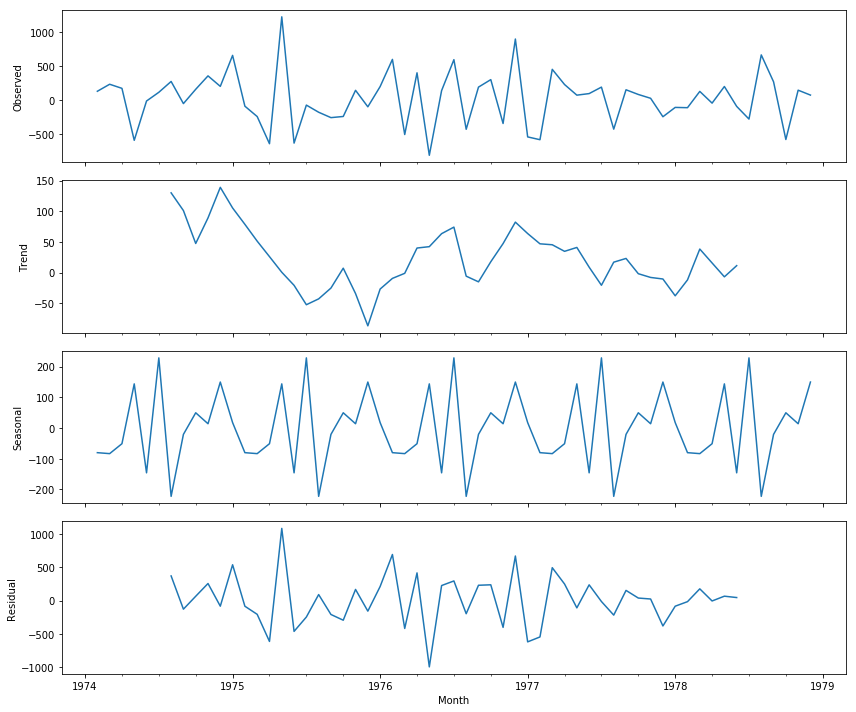

In [19]:
deaths['num_deaths_diff2'] = deaths['num_deaths_diff'] - \
                             deaths['num_deaths_diff'].shift(1)
sm.tsa.seasonal_decompose(deaths['num_deaths_diff2'][13:]).plot()
print("Dickey-Fuller criterion: p=%f" % sm.tsa.stattools.adfuller(deaths['num_deaths_diff2'][13:])[1])

Non-stationarity hypothesis is now rejected, and graphs look all right, no trend anymore.

## Model selection

Let's build ACF and PACF for our time series (seems that there's a bug in PACF, it can't be >1):

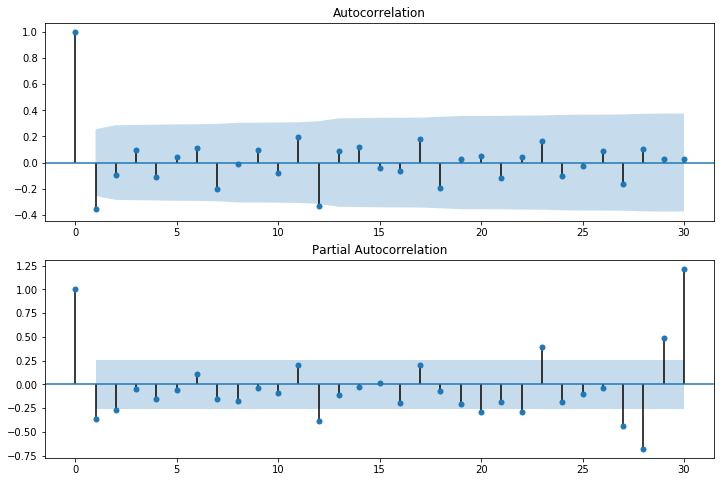

In [20]:
plt.figure(figsize=(12, 8))
ax = plt.subplot(211)
sm.graphics.tsa.plot_acf(deaths['num_deaths_diff2'][13:].values.squeeze(), 
                         lags=30, ax=ax)
ax = plt.subplot(212)
sm.graphics.tsa.plot_pacf(deaths['num_deaths_diff2'][13:].values.squeeze(), 
                          lags=30, ax=ax);

Initial values: Q=2, q=1, P=2, p=2.
Setting these is not obligatory, but if we do so, we'll perform less computations tuning hyperparams.

In [21]:
ps = range(0, 3)
d=1
qs = range(0, 1)
Ps = range(0, 3)
D=1
Qs = range(0, 3)

In [22]:
parameters = product(ps, qs, Ps, Qs)
parameters_list = list(parameters)
len(parameters_list)

27

In [23]:
%%time
results = []
best_aic = float("inf")

warnings.filterwarnings('ignore')

for param in parameters_list:
    #try except is needed because some parameter combinations are not valid
    try:
        model=sm.tsa.statespace.SARIMAX(deaths['num_deaths'], order=(param[0], d, param[1]), 
                                        seasonal_order=(param[2], D, 
                                                        param[3], 12)).fit(disp=-1)
    except ValueError:
        print('wrong parameters:', param)
        continue
    aic = model.aic
    # save best model, it's AIC and params
    if aic < best_aic:
        best_model = model
        best_aic = aic
        best_param = param
    results.append([param, model.aic])
    
warnings.filterwarnings('default')

wrong parameters: (0, 0, 0, 2)
wrong parameters: (0, 0, 1, 2)
wrong parameters: (0, 0, 2, 2)
wrong parameters: (1, 0, 0, 2)
wrong parameters: (1, 0, 1, 2)
wrong parameters: (1, 0, 2, 2)
wrong parameters: (2, 0, 0, 2)
wrong parameters: (2, 0, 1, 2)
wrong parameters: (2, 0, 2, 2)
CPU times: user 27.5 s, sys: 21.1 s, total: 48.6 s
Wall time: 12.3 s


In [24]:
result_table = pd.DataFrame(results)
result_table.columns = ['parameters', 'aic']
print(result_table.sort_values(by = 'aic', ascending=True).head())

      parameters         aic
13  (2, 0, 0, 1)  854.647098
7   (1, 0, 0, 1)  855.458079
16  (2, 0, 2, 0)  856.494101
15  (2, 0, 1, 1)  856.614483
10  (1, 0, 2, 0)  856.648917


Best model:

In [25]:
print(best_model.summary())

                                 Statespace Model Results                                 
Dep. Variable:                         num_deaths   No. Observations:                   72
Model:             SARIMAX(2, 1, 0)x(0, 1, 1, 12)   Log Likelihood                -423.324
Date:                            Tue, 07 Jul 2020   AIC                            854.647
Time:                                    03:56:03   BIC                            862.957
Sample:                                01-01-1973   HQIC                           857.891
                                     - 12-01-1978                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.3724      0.112     -3.329      0.001      -0.592      -0.153
ar.L2         -0.1960      0.170   

Its residuals:

Student's criterion: p=0.274373
Dickey-Fuller criterion: p=0.000000


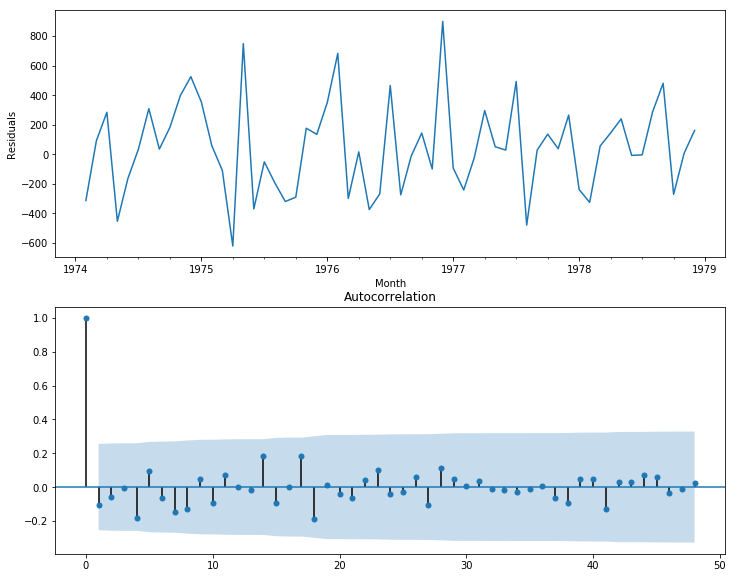

In [26]:
plt.subplot(211)
best_model.resid[13:].plot()
plt.ylabel(u'Residuals')

ax = plt.subplot(212)
sm.graphics.tsa.plot_acf(best_model.resid[13:].values.squeeze(), lags=48, ax=ax)

print("Student's criterion: p=%f" % stats.ttest_1samp(best_model.resid[13:], 0)[1])
print("Dickey-Fuller criterion: p=%f" % sm.tsa.stattools.adfuller(best_model.resid[13:])[1])

Residuals are not biased (confirmed by the Student's criterion), are stationary (confirmed by the Dickey-Fuller criterion) and not auto-correlated (confirmed by the Ljung-Box criterion and correlogram).
Let's see how well the model fits data:

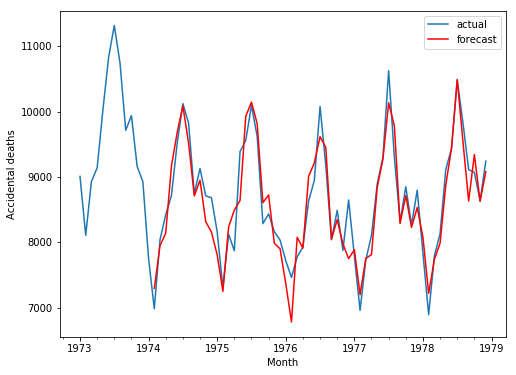

In [27]:
plt.figure(figsize=(8, 6))
deaths['model'] = best_model.fittedvalues
deaths['num_deaths'].plot(label='actual')
deaths['model'][13:].plot(color='r', label='forecast')
plt.ylabel('Accidental deaths')
plt.legend();

### Forecast

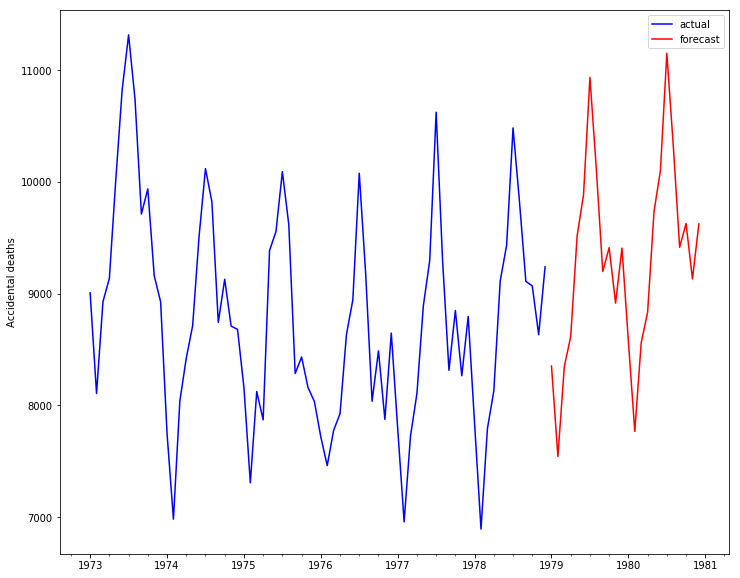

In [28]:
from dateutil.relativedelta import relativedelta
deaths2 = deaths[['num_deaths']]
date_list = [pd.datetime.strptime("1979-01-01", "%Y-%m-%d") + relativedelta(months=x) for x in range(0,24)]
future = pd.DataFrame(index=date_list, columns=deaths2.columns)
deaths2 = pd.concat([deaths2, future])
deaths2['forecast'] = best_model.predict(start=72, end=100)

deaths2['num_deaths'].plot(color='b', label='actual')
deaths2['forecast'].plot(color='r', label='forecast')
plt.ylabel('Accidental deaths')
plt.legend();